In [2]:
import pandas as pd

df = pd.read_csv('data/jj.csv')

In [12]:
train_test_split = int(0.96*len(df))
train = df[:train_test_split]
test = df[train_test_split:]
print(len(train), len(test))

80 4


70.01


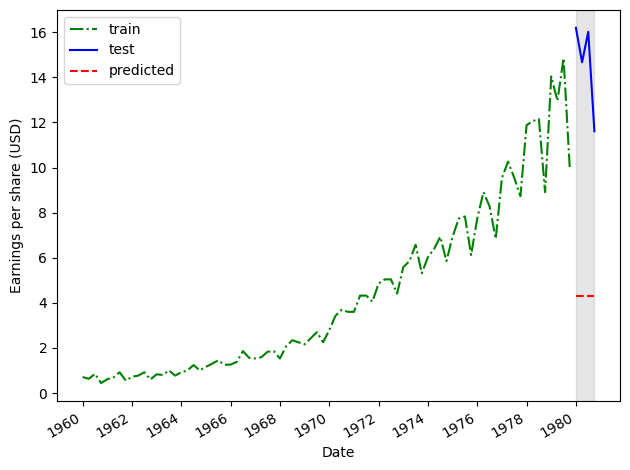

In [43]:
import numpy as np

# super terrible historical mean baseline

historical_mean = np.mean(train['data'])

test = test.assign(pred_mean = historical_mean)

# mean absolute % error
def mape(y_true: np.ndarray, y_pred: np.ndarray):
    return np.mean(np.abs((y_true-y_pred)/y_true))*100

def eval_model(
    train: pd.DataFrame,    # train time series
    test: pd.DataFrame,     # test time series
    predicted_col: str      # name of the column in the test df that contains the predictions
):
    # evaluates the model on the test set
    # does a simple mean abs % error calculation
    # and plots the train, test, and predicted values on the same graph
    
    mape_hist_mean = mape(test['data'], test[predicted_col])
    print(f'{mape_hist_mean:.2f}')

    import matplotlib.pyplot as plt
    from matplotlib.axes import Axes
    import datetime

    fig, ax = plt.subplots()
    ax: Axes
    ax.plot(train['date'], train['data'], 'g-.', label='train')
    ax.plot(test['date'], test['data'], 'b-', label='test')
    ax.plot(test['date'], test[predicted_col], 'r--', label='predicted')
    ax.set_xlabel('Date')
    ax.set_ylabel('Earnings per share (USD)')
    ax.axvspan(train_test_split, len(df)-1, color='#808080', alpha=0.2)
    ax.legend(loc=2)
    plt.xticks(
        np.arange(0, len(df), 8), # 8 quarters
        [datetime.datetime.strptime(d, '%Y-%m-%d').year for d in df['date'][::8]],
    )
    fig.autofmt_xdate()
    plt.tight_layout()

eval_model(train, test, 'pred_mean')

15.60


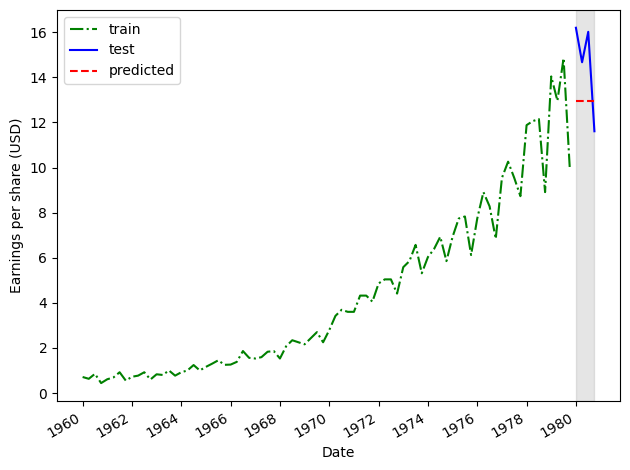

In [44]:
last_year_mean = np.mean(train['data'][-4:])
test = test.assign(last_year_mean = last_year_mean)
eval_model(train, test, 'last_year_mean')

By using the mean of the last year in our training set to forecast the following year, we achieve a far better MAPE than using the mean of the entire training set. Thus, future values depend on past values not too far back in history, this is a sign of *autocorrelation*.

30.46


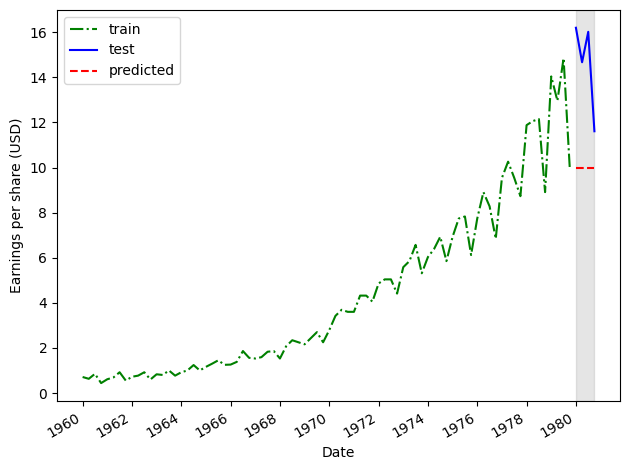

In [46]:
last = train['data'].iloc[-1]
test = test.assign(pred_last = last)
eval_model(train, test, 'pred_last')

EPS display a cyclical behavior, where it is high during the first 3 quarters and falls in the 4th. Using the last value did not take seasonality into account.

11.56


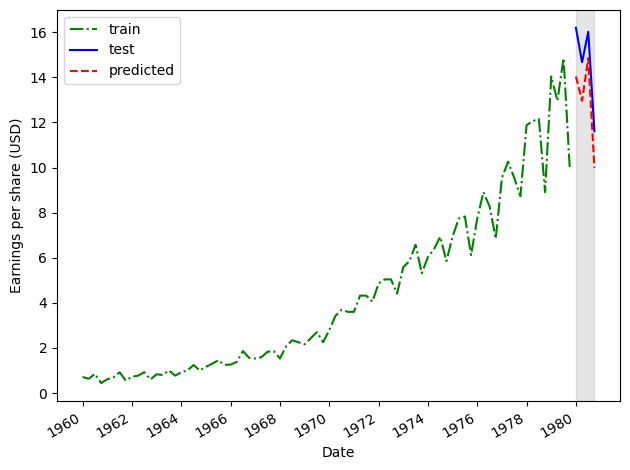

In [52]:
test = test.assign(pred_last_season = train['data'].iloc[-4:].values)
eval_model(train, test, 'pred_last_season')

Our naive seasonal forecasting has resulted in the lowest MAPE of all the baselines built so far. Seasonality has a significant impact on future values, since repeating the last season into the future yields (relatively) better forecasts. Intuitively, this makes sense since we can observe a cyclical pattern every year in plot.

Baseline models only serve as a basis comparison, not to be used in practice. If a complex model has a higher MAPE than every baseline (hist mean, last year mean, last, naive seasonal) on the same dataset, than it is a better performing model.